In [1]:
'''
    Generate simulated data
'''

'\n    Generate simulated data\n'

In [2]:
import pandas as pd
import numpy as np
import logistic_regression as lr
import matplotlib.pyplot as plt

In [120]:
g = np.random.uniform(0,1, size=(10000,20))
intercept = np.ones((10000,1))
g = np.concatenate((intercept, g), axis=1)

In [121]:
#num_features = len(g.columns)
num_features = g.shape[1]
lambda_hp_children_dict = {'brain': 0.562229, 'group1': 0.75696656, 'muscle': 1.51665066, 'epithelial': 2.22486734, 'digestive': 5.17309994}
tissues = ['brain', 'group1', 'muscle', 'epithelial', 'digestive']

In [166]:
def _simulate_alpha(sd):
    '''
        Generate alpha parameter where alpha ~ N(0, variance)
    '''
    return np.random.normal(np.zeros(num_features), sd)

In [167]:
def _simulate_beta_given_alpha(alpha, sd):
    '''
        Generate beta | alpha ~ N(alpha, sigma)
    '''
    return np.random.normal(alpha, sd)

In [168]:
def _simulate_beta_no_parent(sd):
    '''
        Generate beta ~ N(0, sigma)
    '''
    return np.random.normal(np.zeros(num_features), sd)

In [169]:
def _simulate_z_given_g():
    '''
        Generate Z given g and beta
            - predict p(z|g)
            - using prediction vector, sample from bernoulli with prediction as weight
    '''
    p_z_given_g = _compute_p_z_given_g(beta, g)
    z_draws = np.random.binomial(1, p_z_given_g)
    return z_draws

def _compute_p_z_given_g(beta, g):
    '''
        Compute p(z|g;beta)
    '''
    return np.exp(lr.log_prob(g, beta))

In [170]:
def _simulate_e_given_z(z, phi):
    '''
        Generate E given Z, phi
        for each z, sample from bernoulli with e=1|z=a parameter as weight.
    '''
    
    return 1


In [310]:
def _simulate_phi(mu_z0, mu_z1, var_z0, var_z1):
    '''
        Using a beta distribution, sample phi counts
        
        fix this function
        
    '''
    # p(e=1|z=0), p(e=1|z=1)
    phi = np.zeros(2)
    
    alpha, beta = _compute_beta_hyperparameters(mu_z0, var_z0)
    
    # sample from Beta
    phi[0] = np.random.beta(alpha, beta)
    
    alpha, beta = _compute_beta_hyperparameters(mu_z1, var_z1)

    # sample from Beta
    phi[1] = np.random.beta(alpha, beta)
    
    return phi

In [315]:
_simulate_phi(0.3, 0.7, 0.0001, 0.0001)

array([ 0.28749274,  0.69435993])

In [40]:
def _compute_beta_hyperparameters(mu, var):
    '''
        Compute beta distribution parameters given a desired mean and variance
    '''
    alpha = (((1 - mu) / var) - (1 / mu)) * mu**2
    beta = alpha * (1/mu - 1)
    return alpha, beta

In [128]:
def _simulate_RIVER():
    lambda_hp = 4.333047702488766
    alpha_variance = 1.0 / lambda_hp_parent
    # simulate beta
    beta = _simulate_beta_no_parent(alpha_variance)
    # compute p(z | g, beta)
    p_z_given_g = _compute_p_z_given_g(beta, g)
    # generate z given p(z|g)
    z_draws = np.random.binomial(1, p_z_given_g)
    # simulate phi and beta
    phi = _simulate_phi()
    # generate e
    e_draws = np.random.binomial(1, phi[z_draws])
    
    np.savetxt("../input/simulated_data/RIVER/e.txt", e_draws)
    np.savetxt("../input/simulated_data/RIVER/g.txt", g)
    np.savetxt("../input/simulated_data/RIVER/z.txt", z_draws)
    np.savetxt("../input/simulated_data/RIVER/beta.txt", beta)
    np.savetxt("../input/simulated_data/RIVER/phi.txt", phi)
    

[ 0.40392158  0.30652061  0.29809837 ...,  0.45923314  0.48325975
  0.37638936]
0.4423
[ 0.3571938   0.31394663  0.60625239 ...,  0.44068361  0.64866976
  0.4615829 ]
0.513
[ 0.20185505  0.09753019  0.10441309 ...,  0.18245008  0.23558922
  0.28765518]
0.2022
[ 0.67975142  0.70809021  0.4134394  ...,  0.64885105  0.51276711
  0.42559907]
0.4692
[ 0.46855723  0.89657417  0.62263499 ...,  0.51980039  0.68958141
  0.72586122]
0.7154


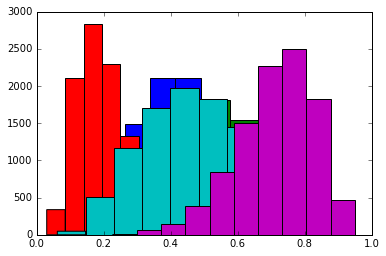

In [346]:
def _simulate_multitask_no_transfer():
    # e = 1 | z = 0
    mu_z0 = 0.4
    # e = 1 | z = 1
    mu_z1 = 0.6
    tissues = ['brain', 'group1', 'muscle', 'epithelial', 'digestive']
    e = pd.DataFrame()
    z = pd.DataFrame()
    betas = []
    lambda_hp = .1
    alpha_sd = (1.0 / lambda_hp_parent) ** (.5)
    # simulate phi using beta distribution (do this step once and use for all tissues)
    phi = _simulate_phi(mu_z0, mu_z1, 0.0001, 0.0001)
    for tissue in tissues:
        # simulate beta
        beta = _simulate_beta_no_parent(alpha_sd)
        betas.append(beta)
        # compute p(z | g, beta)
        p_z_given_g = _compute_p_z_given_g(beta, g)
        print(p_z_given_g)
        plt.hist(p_z_given_g)
        # generate z given p(z|g)
        z_draws = np.random.binomial(1, p_z_given_g)
        z[tissue] = z_draws
        print(np.count_nonzero(z_draws)/len(z_draws))
        # generate e
        e_draws = np.random.binomial(1, phi[z_draws])
        e[tissue] = e_draws
    return e, z, pd.DataFrame(betas, index=tissues), phi, 
e, z, betas, phi = _simulate_multitask_no_transfer()

[ 0.76961846  0.9983158   0.05444099 ...,  0.73118192  0.99572261
  0.99280223]
0.7812
[ 0.98080469  0.999985    0.34240883 ...,  0.97677316  0.99992886
  0.99981732]
0.9396
[ 0.92402612  0.99986263  0.10410568 ...,  0.88473089  0.99941774
  0.99885617]
0.8656
[ 0.96755833  0.99977573  0.08616221 ...,  0.97353988  0.99971775
  0.99457727]
0.8866
[ 0.98525986  0.99995123  0.37045198 ...,  0.98160466  0.99992588
  0.99977944]
0.9448


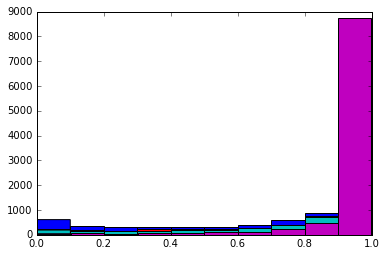

In [344]:
%matplotlib inline
def _simulate_multitask_with_transfer():
    # e = 1 | z = 0
    mu_z0 = 0.4
    # e = 1 | z = 1
    mu_z1 = 0.6
    
    lambda_hp_children_dict = {'brain': 4, 'group1': 5, 'muscle': 6, 'epithelial': 7, 'digestive': 8}
    e = pd.DataFrame()
    z = pd.DataFrame()
    betas = []
    lambda_hp_parent = .1
    # square root of the variance
    alpha_sd = (1.0 / lambda_hp_parent) ** (.5)
    alpha = _simulate_alpha(alpha_sd)
    # generate phi from Beta distribution
    phi = _simulate_phi(mu_z0, mu_z1, 0.0001, 0.0001)
    for tissue in tissues:
        sd = (1.0 / lambda_hp_children_dict[tissue]) ** (.5)
        beta = _simulate_beta_given_alpha(alpha, sd)
        betas.append(beta)
        # compute p(z | g, beta)
        p_z_given_g = _compute_p_z_given_g(beta, g)
        print(p_z_given_g)
        plt.hist(p_z_given_g)
        # generate z given p(z|g)
        z_draws = np.random.binomial(1, p_z_given_g)
        print(np.count_nonzero(z_draws)/len(z_draws))
        z[tissue] = z_draws
        # generate e
        e_draws = np.random.binomial(1, phi[z_draws])
        e[tissue] = e_draws
        
    return e, z, pd.DataFrame(betas, index=tissues), phi,
e, z, betas, phi = _simulate_multitask_with_transfer()


In [345]:
#e, z, betas, phi = _simulate_multitask_with_transfer()
np.savetxt("../input/simulated_data/multitask_with_transfer/g.csv", g, delimiter=",")
e.to_csv("../input/simulated_data/multitask_with_transfer/e.csv")
z.to_csv("../input/simulated_data/multitask_with_transfer/z.csv")
betas.to_csv("../input/simulated_data/multitask_with_transfer/betas.csv")
np.savetxt("../input/simulated_data/multitask_with_transfer/phi.txt", phi)

In [347]:
#e, z, betas, phi = _simulate_multitask_with_transfer()
np.savetxt("../input/simulated_data/multitask_no_transfer/g.csv", g, delimiter=",")
e.to_csv("../input/simulated_data/multitask_no_transfer/e.csv")
z.to_csv("../input/simulated_data/multitask_no_transfer/z.csv")
betas.to_csv("../input/simulated_data/multitask_no_transfer/betas.csv")
np.savetxt("../input/simulated_data/multitask_no_transfer/phi.txt", phi)

In [1]:
import os

In [3]:
not os.path.isdir("./hi")

True

In [4]:
os.makedirs("./hi")